In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = 30, 20
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [221]:
# read in adjusted_closing price dataset
def read_df(csv_file):
    
    df = pd.read_csv(csv_file, index_col=0)
    
    return df

#df = read_df('casino_stocks.csv')
#df.head()

In [8]:
def get_data(symbol_list):
    
    for sym in symbol_list:
        df_adj_closed = pd.read_csv('data/{}.csv'.format(sym), index_col='Date', parse_dates=True, na_values=['nan'], usecols=['Date', 'Adj Close'])
        df_adj_closed = df_adj_closed.rename(columns={'Adj Close': 'adj_close'})
        df_adj_closed.dropna(inplace=True)
    
    return df_adj_closed

In [215]:
#symbols = ['SPY', 'BYD', 'CZR', 'LVS', 'MGM', 'PENN', 'PK', 'WYNN']

In [216]:
# for sym in symbols:
#     df_temp = pd.read_csv('data/{}.csv'.format(sym), index_col='Date', parse_dates=True, na_values=['nan'], usecols=['Date', 'Adj Close'])
#     df_temp = df_temp.rename(columns={'Adj Close': sym})
#     df_adj_closed = df_adj_closed.join(df_temp)
#     df_adj_closed.dropna(inplace=True)

In [217]:
#df_adj_closed.to_csv('casino_stocks.csv')

In [218]:
#df_adj_closed.plot()

In [143]:
#df_adj_closed.pct_change().round(3)

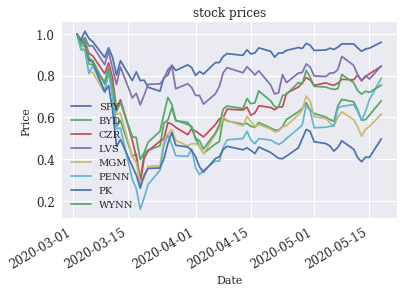

In [222]:
def plot_df(df, title='stock prices'):
    
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.show()
    
    
plot_df(df_norm)

In [145]:
# resample by week
df_adj_closed.resample('1w', label='right').last().head()

,SPY,BYD,CZR,LVS,MGM,PENN,PK,WYNN
2020-03-08,295.721069,22.33,11.09,53.786976,20.24,23.91,15.446553,94.029999
2020-03-15,267.745575,15.34,8.49,48.051395,15.44,15.47,8.833379,72.519997
2020-03-22,228.800003,11.60,5.45,43.310001,9.11,7.89,6.356997,51.970001
2020-03-29,253.419998,15.30,6.85,42.099998,12.19,11.77,8.340000,63.310001
2020-04-05,248.190002,11.22,6.28,37.919998,10.58,9.77,6.040000,48.500000


In [202]:
def train_valid_data(df):
    
    # splitting into train and validation
    row = int(df.shape[0] * 0.8)
    train = df[:row]
    valid = df[row:]
    return train,valid

train, valid = train_valid_data(get_data(['PK']))

In [203]:
# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of training set:
(201, 1)

 Shape of validation set:
(51, 1)


In [204]:
def predict_moving_average(df):
    
    train = train_valid_data(df)[0]
    preds = []
    for i in range(0,valid.shape[0]):
        a = train['adj_close'][len(train)-50+i:].sum() + sum(preds)
        b = a/50
        preds.append(b)
        
    return preds

def RMSE(preds, actual):
    rmse = np.sqrt(np.mean(np.power((np.array(actual)-preds),2)))
    return rmse

####function test#####
df = get_data(['PK'])
train, valid = train_valid_data(df)
preds = predict_moving_average(train)

rmse_pk = RMSE(preds, valid)

C:\Users\shi yan\Anaconda3\envs\fastai2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


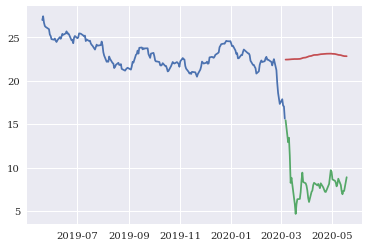

In [212]:
#plot
def plot_rmse_MA(df):
    
    train, valid = train, valid = train_valid_data(df)
    valid['predictions'] = predict_moving_average(train)
    plt.plot(train['adj_close'])
    plt.plot(valid[['adj_close', 'predictions']])
    
df = get_data(['PK'])
plot_rmse_MA(get_data(['PK']))

## Conclusion:

In general regression methods that take into account indepent features such as KNN, Linear Regression won't perform really well.

Moving Average is also too simplistic because it is simply summarizing neighborly data without capturing more nuanced pattern.

## Time Series Method

> So we will use auto ARIMA which automatically selects the best combination of (p,q,d) that provides the least error.

[predicting stock prices](https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/?#)

In [229]:
from pyramid.arima import auto_arima

df = get_data(['PK'])
data = df.sort_index(ascending=True, axis=0)

train = data[:201]
valid = data[201:]

training = train['adj_close']
validation = valid['adj_close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, 
                   seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=51)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=196.022, BIC=212.204, Fit time=1.057 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=280.769, BIC=287.242, Fit time=0.144 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=226.008, BIC=238.953, Fit time=0.523 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=198.121, BIC=211.066, Fit time=0.800 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=197.931, BIC=217.349, Fit time=1.056 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=261.922, BIC=274.868, Fit time=0.202 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=197.926, BIC=217.344, Fit time=5.809 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=199.876, BIC=222.531, Fit time=9.736 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=197.454, BIC=216.872, Fit time=2.129 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 

In [3]:
#plot
plt.plot(train['adj_close'], color='grey')
plt.plot(valid['adj_close'], color='y')
plt.plot(forecast['Prediction'], color='green')

NameError: name 'train' is not defined

## ARIMA certainly improves because the the predicted values certainly follows the trend of the actual values.

In [3]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

C:\Users\shi yan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
####### My Model ########

In [4]:
def get_scaler():
    
    return MinMaxScaler(feature_range=(0, 1))

In [5]:
scaler_obj = get_scaler()

In [13]:
def train_lstm(tick_name, scaler_obj, timestep=10, epochs=20):
    
    # get data series
    df_tick = get_data([tick_name])
    dataset_tick = df_tick.values
    
    # split into train and test
    num_train = int(len(dataset_tick) * 0.8)
    train_tick = dataset_tick[0:num_train, :]
    valid_tick = dataset_tick[num_train:, :]
    
    # scale the data
    scaled_tick_data = scaler_obj.fit_transform(dataset_tick)
    
    # make training data for LSTM model
    x_tick_train, y_tick_train = [], []
    for i in range(timestep, len(train_tick)):
        x_tick_train.append(scaled_tick_data[i-timestep:i,0])
        y_tick_train.append(scaled_tick_data[i,0])
        
    x_tick_train, y_tick_train = np.array(x_tick_train), np.array(y_tick_train)

    x_tick_train = np.reshape(x_tick_train, (x_tick_train.shape[0], x_tick_train.shape[1], 1))
    
    # create and fit the LSTM network
    model_tick = Sequential()
    model_tick.add(LSTM(units=32, return_sequences=True, input_shape=(x_tick_train.shape[1],1)))
    model_tick.add(LSTM(units=16))
    model_tick.add(Dense(1))

    model_tick.compile(loss='mean_squared_error', optimizer='adam')
    model_tick.fit(x_tick_train, y_tick_train, batch_size=1, epochs=epochs, verbose=2)
    
    return model_tick

In [14]:
model_pk = train_lstm('PK', scaler_obj, timestep=10)

Epoch 1/20
 - 4s - loss: 0.0580
Epoch 2/20
 - 2s - loss: 0.0035
Epoch 3/20
 - 2s - loss: 0.0029
Epoch 4/20
 - 2s - loss: 0.0030
Epoch 5/20
 - 2s - loss: 0.0027
Epoch 6/20
 - 2s - loss: 0.0030
Epoch 7/20
 - 2s - loss: 0.0032
Epoch 8/20
 - 2s - loss: 0.0028
Epoch 9/20
 - 2s - loss: 0.0025
Epoch 10/20
 - 3s - loss: 0.0025
Epoch 11/20
 - 3s - loss: 0.0026
Epoch 12/20
 - 3s - loss: 0.0020
Epoch 13/20
 - 3s - loss: 0.0022
Epoch 14/20
 - 2s - loss: 0.0019
Epoch 15/20
 - 2s - loss: 0.0019
Epoch 16/20
 - 2s - loss: 0.0018
Epoch 17/20
 - 2s - loss: 0.0024
Epoch 18/20
 - 2s - loss: 0.0016
Epoch 19/20
 - 2s - loss: 0.0016
Epoch 20/20
 - 3s - loss: 0.0016


In [78]:
# scaler_pk = MinMaxScaler(feature_range=(0, 1))
# scaled_pk_data = scaler_pk.fit_transform(dataset_pk)

In [82]:
# x_pk_train, y_pk_train = [], []
# for i in range(10,len(train_pk)):
#     x_pk_train.append(scaled_pk_data[i-10:i,0])
#     y_pk_train.append(scaled_pk_data[i,0])
# x_pk_train, y_pk_train = np.array(x_pk_train), np.array(y_pk_train)

# x_pk_train = np.reshape(x_pk_train, (x_pk_train.shape[0], x_pk_train.shape[1], 1))

In [17]:
x_pred_pk = prep_past_data('PK', scaler_obj, 10)

In [16]:
def prep_past_data(tick_name, scaler_obj, timestep=10):
    
    #get data series
    df_tick = get_data([tick_name])
    dataset_tick = df_tick.values
    
    num_valid = len(dataset_tick)-int(len(dataset_tick) * 0.8)
    inputs = df_tick[len(dataset_tick) - num_valid - timestep:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler_obj.transform(inputs)

    X_pred_tick = []
    for i in range(timestep,inputs.shape[0]):
        X_pred_tick.append(inputs[i-timestep:i,0])
        
    X_pred_tick = np.array(X_pred_tick)

    X_pred_tick = np.reshape(X_pred_tick, (X_pred_tick.shape[0], X_pred_tick.shape[1],1))
    
    return X_pred_tick

def lstm_predict(X_pred_tick, model_tick, scaler_obj, next_n_days):
    # make prediction
    closing_prices = model_tick.predict(X_pred_tick)
    closing_prices = scaler_obj.inverse_transform(closing_prices)
    
    return closing_prices[:next_n_days]

In [21]:
closing_pk_prices = lstm_predict(x_pred_pk, model_pk, scaler_obj, next_n_days=7)

In [22]:
closing_pk_prices

array([[17.520739],
       [17.035294],
       [16.314333],
       [15.702115],
       [14.95617 ],
       [13.917659],
       [12.993085]], dtype=float32)

In [194]:
df_tick = get_data(['PENN'])
dataset_tick = df_tick.values
num_valid = len(dataset_tick)-int(len(dataset_tick) * 0.8)
len(dataset_tick) - num_valid - 10

191

In [195]:
len(closing_penn_prices)

51

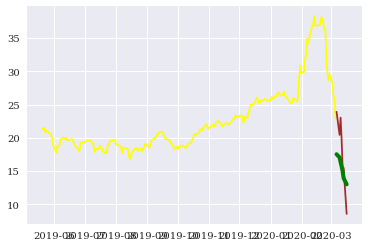

In [27]:
#for plotting

def plot_predicted_prices(tick_name, closing_tick_prices):

    df_tick = get_data([tick_name])
    train_tick = df_tick[:int(df_tick.shape[0] * 0.8)]
    valid_tick = df_tick[int(df_tick.shape[0] * 0.8):][:len(closing_tick_prices)]

    
    ax = plt.gca()

    valid_tick['predictions'] = closing_tick_prices
    plt.plot(train_tick['adj_close'], color = 'yellow')
    plt.plot(valid_tick['adj_close'], color = 'brown')
    plt.plot(valid_tick['predictions'], color = 'green', linewidth=4)
    
plot_predicted_prices('PENN', closing_pk_prices)

In [40]:
for i in range(len(closing_pk_prices)):
    print('$',float(closing_pk_prices[i]))



$ 17.52073860168457
$ 17.035293579101562
$ 16.314332962036133
$ 15.702115058898926
$ 14.956170082092285
$ 13.917658805847168
$ 12.993084907531738


In [31]:
[18.37628].astype(float)

AttributeError: 'list' object has no attribute 'astype'

In [66]:
def normalize_data(df):
    return df/df.iloc[0]

ax = df_norm['SPY'].plot(title='rolling mean', label='SPY')
rm_spy = df_norm['SPY'].rolling(20).mean() 
rm_spy.plot(title='rolling mean', ax=ax)

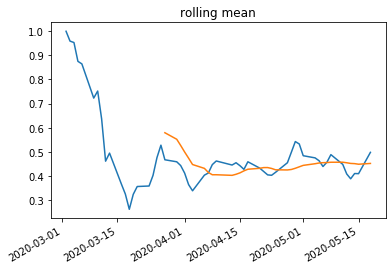

In [87]:
ax = df_norm['PK'].plot(title='rolling mean', label='PK')
rm_pk = df_norm['PK'].rolling(20).mean() 
rm_pk.plot(title='rolling mean', ax=ax)

In [96]:
def compute_daily_returns(df):
    
    daily_returns = df.copy()
    daily_returns = (df/df.shift(1)) - 1
    
    return daily_returns

daily_return_pk = compute_daily_returns(df['PK'])
daily_return_spy = compute_daily_returns(df['SPY'])

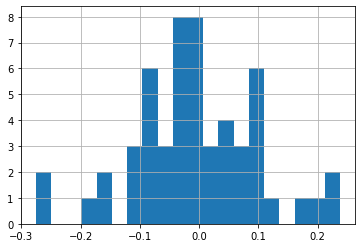

In [101]:
daily_return_pk.hist(bins=20)

In [102]:
# get mean and std

mean_pk = daily_return_pk.mean()
std_pk = daily_return_pk.std()
mean_pk, std_pk

(-0.007162501540953116, 0.10603779538338332)

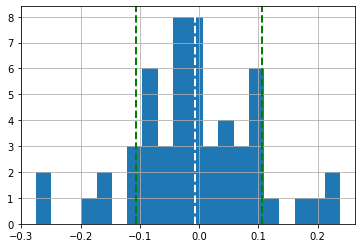

In [108]:
daily_return_pk.hist(bins=20)
plt.axvline(mean_pk, color='w', linestyle='dashed', linewidth=2)
plt.axvline(-std_pk, color='green', linestyle='dashed', linewidth=2)
plt.axvline(std_pk, color='green', linestyle='dashed', linewidth=2)
plt.show()

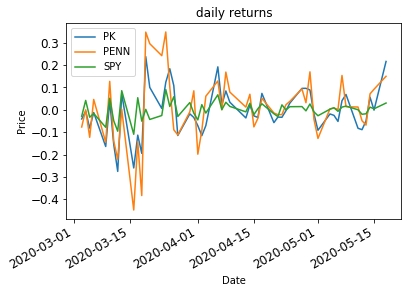

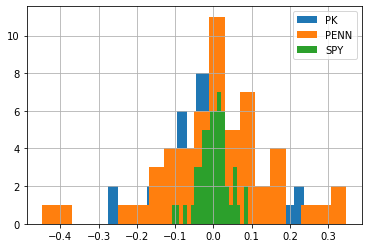

In [127]:
data = get_data(['PK', 'PENN', 'SPY'])
#plot_df(data)
daily_returns = compute_daily_returns(data)
plot_df(daily_returns, title='daily returns')

# compute and plot two histograms on the same chart
daily_returns['PK'].hist(bins=20, label='PK')
daily_returns['PENN'].hist(bins=20, label='PENN')
daily_returns['SPY'].hist(bins=20, label='SPY')
plt.legend(loc='upper right')
plt.show()


,PK,PENN,SPY
PK,1.000000,0.807704,0.681019
PENN,0.807704,1.000000,0.551131
SPY,0.681019,0.551131,1.000000


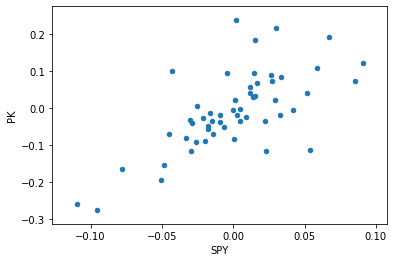

In [136]:
daily_returns.plot(kind='scatter', x='SPY', y='PK')
#np.polyfit(daily_returns['SPY'], daily_returns['PENN'])
daily_returns.corr(method='pearson')

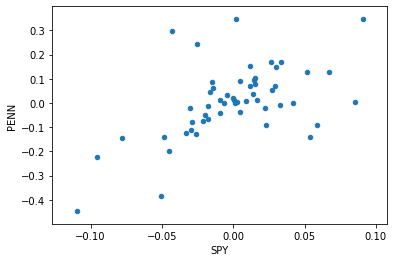

In [129]:
daily_returns.plot(kind='scatter', x='SPY', y='PENN')